# Proximity analysis
In this notebook we will be working with data from [OpenStreetMap](https://openstreetmap.org) to do proximity analysis to various urban amenities.

In [1]:
import folium
import geopandas
import pyproj
from shapely.ops import transform

%matplotlib inline

## Import data

In [2]:
food_sources_file_name = "data/Tampere-food_sources.geojson"
building_footprints_file_name = "data/Tampere-buildings.gpkg"

In [3]:
food_sources = geopandas.read_file(food_sources_file_name)
buildings = geopandas.read_file(building_footprints_file_name)

## Use OSM for GeoDataFrame index

In [4]:
buildings.set_index("osm_id", inplace=True, verify_integrity=True)

In [5]:
food_sources.set_index("osm_id", inplace=True, verify_integrity=True)

In [6]:
buildings.shape

(16433, 5)

## Building centroids

In [7]:
building_centroids = buildings["geometry"].centroid

In [8]:
building_centroids.head()

osm_id
4881423    POINT (2630225.788 8742972.055)
4881551    POINT (2634757.358 8743507.709)
4983894    POINT (2637191.237 8743327.620)
4983896    POINT (2637257.370 8743316.543)
4983916    POINT (2637019.994 8743543.104)
dtype: geometry

In [9]:
type(building_centroids)

geopandas.geoseries.GeoSeries

## Create buffers

In [10]:
one_km = 1000

food_sources_buffered = food_sources.buffer(one_km)

type(food_sources_buffered)

geopandas.geoseries.GeoSeries

## Dissolve buffers

In [11]:
food_sources_buffered_union = food_sources_buffered.unary_union
type(food_sources_buffered_union)

shapely.geometry.multipolygon.MultiPolygon

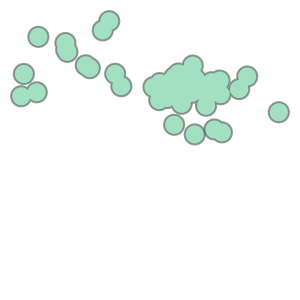

In [12]:
food_sources_buffered_union

## Buildings within food catchment

In [13]:
%%time
buildings_within_food_catchment = building_centroids.within(food_sources_buffered_union)

CPU times: user 9.34 s, sys: 145 ms, total: 9.48 s
Wall time: 9.57 s


In [14]:
buildings_within_food_catchment.rename("within_food_catchment", inplace=True)

osm_id
4881423       True
4881551      False
4983894       True
4983896       True
4983916       True
             ...  
808953576    False
808953577    False
808953586    False
1305873      False
812390789    False
Name: within_food_catchment, Length: 16433, dtype: bool

In [24]:
buildings = buildings.join(buildings_within_food_catchment)

In [30]:
buildings.head()

,code,fclass,name,type,geometry,within_food_catchment
osm_id,,,,,,
4881423,1500,building,Tesoman liikekeskus,retail,"MULTIPOLYGON (((2630165.146 8743043.051, 26302...",True
4881551,1500,building,K-Market Winterinmutka,retail,"MULTIPOLYGON (((2634712.146 8743523.360, 26347...",False
4983894,1500,building,None,None,"MULTIPOLYGON (((2637171.795 8743326.127, 26371...",True
4983896,1500,building,None,None,"MULTIPOLYGON (((2637238.575 8743314.366, 26372...",True
4983916,1500,building,None,None,"MULTIPOLYGON (((2636996.066 8743546.463, 26370...",True


<AxesSubplot:>

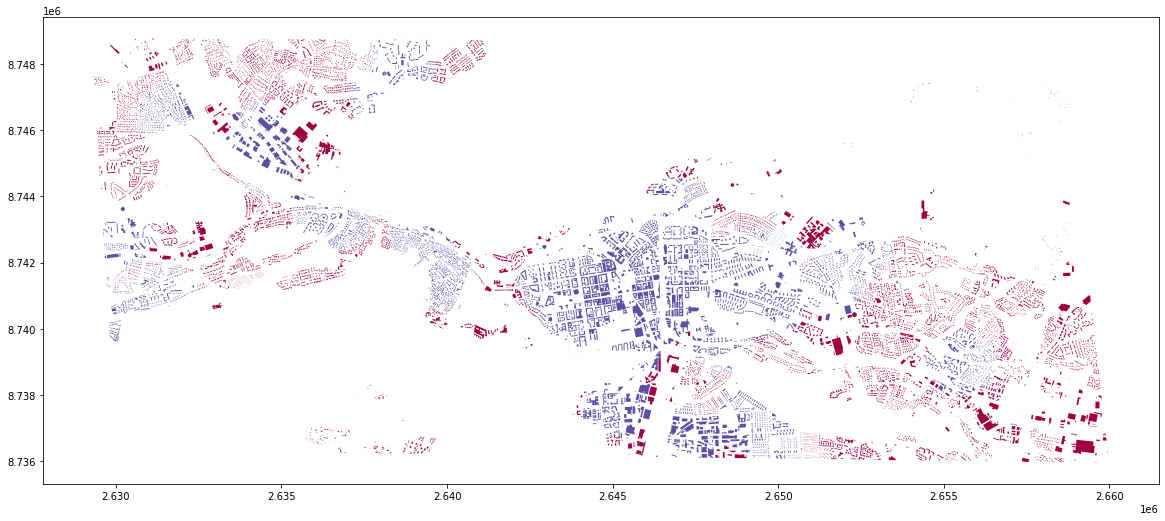

In [29]:
buildings.plot(categorical=True, column="within_food_catchment",figsize=(20, 15), cmap='Spectral')

## Convert coordinates
We need to change the coordinate reference system in order to display the data correctly in Foliu

In [13]:
food_sources_4326 = food_sources.to_crs(epsg='4326')
buildings_4326 = buildings.to_crs(epsg='4326')

In [14]:
projection = pyproj.Transformer.from_proj(
    pyproj.Proj(init='epsg:3857'),
    pyproj.Proj(init='epsg:4326')
)

food_sources_buffered_union_4326 = transform(projection.transform, food_sources_buffered_union)

/home/brylie/.cache/pypoetry/virtualenvs/suds-notebooks-maDYyLUp-py3.8/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/brylie/.cache/pypoetry/virtualenvs/suds-notebooks-maDYyLUp-py3.8/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/brylie/.cache/pypoetry/virtualenvs/suds-notebooks-maDYyLUp-py3.8/lib/python3.8/site-packages/pyproj/c

## Data to GeoJSON

In [15]:
food_sources_4326_json = food_sources_4326.to_json()
food_sources_buffered_union_4326_json = geopandas.GeoSeries([food_sources_buffered_union_4326]).to_json()
buildings_4326_json = buildings_4326.to_json()

TypeError: Object of type Point is not JSON serializable

In [ ]:
type(geopandas.GeoSeries([food_sources_buffered_union_4326]))

## Create map
Next, we will display a map centered around Tampere.

In [ ]:
center_coordinates = [61.4978, 23.7610]

In [ ]:
map = folium.Map(center_coordinates)

## Add data to map
Now we can add the food sources data to the map.

In [ ]:
folium.GeoJson(
    food_sources_4326_json,
    name="Food sources",
).add_to(map)

folium.GeoJson(
    food_sources_buffered_union_4326_json,
    name="Food catchments",
).add_to(map)

folium.GeoJson(
    buildings_4326_json,
    name="Buildings",
).add_to(map)



folium.LayerControl().add_to(map)

In [ ]:
map